ENV: celiac_env_3

In [1]:
import scanpy as sc
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import matplotlib as mpl
import plotly.express as px
from adjustText import adjust_text
from tqdm import tqdm
import gseapy as gp
import os
import warnings
from datetime import datetime
from scipy.stats import zscore
import scipy
from sklearn.decomposition import PCA
import math
from scipy.sparse import issparse
from statsmodels.stats.multitest import multipletests
from scipy.stats import ranksums
import scipy.stats
import dill
import session_info2

np.random.seed(1)

# import py_funcs
import plot_gsea

warnings.filterwarnings("ignore")

mpl.rcParams['pdf.fonttype'] = 42 # to edit text in Illustrator
mpl.rcParams['ps.fonttype'] = 42
plt.rcParams.update({
    "font.size": 14,    
    "axes.titlesize": 16,    
    "axes.labelsize": 14,  
    "xtick.labelsize": 14,
    "ytick.labelsize": 14,  
    "legend.fontsize": 14
})
mpl.rcParams['text.usetex'] = False

# cm = 1/2.54 # centimeters in inches
LOAD_ARIAL = True
if LOAD_ARIAL:
    # set the default font to Arial
    from matplotlib.font_manager import FontProperties, fontManager
    from matplotlib import rcParams
    # Path to Arial font
    arial_path = '/mnt/x/common/joint_projects/spatial_celiac/utils/Arial.ttf'
    arial_bold = '/mnt/x/common/joint_projects/spatial_celiac/utils/Arial Bold.ttf'

    # Define font properties with the specific path
    arial_font = FontProperties(fname=arial_path)
    arial_bold_font = FontProperties(fname=arial_bold)
    fontManager.addfont(arial_path)
    fontManager.addfont(arial_bold)

    # Set the font as the default for all text elements
    # rcParams['font.family'] = arial_font.get_family()
    # rcParams['font.sans-serif'] = [arial_font.get_name()]
    rcParams['font.family'] = 'sans-serif'
    rcParams['font.sans-serif'] = ['Arial']

In [2]:
fast_load = True
if fast_load:
    fast_load_prefix = "/mnt/d/celiac_files/"
else:   
    fast_load_prefix = ""

In [3]:
adata = sc.read_h5ad(fast_load_prefix+"10x_flex_all_samples_processed_bg.h5ad")
adata

AnnData object with n_obs × n_vars = 53270 × 18129
    obs: 'sample_name', 'batch', 'clinical_group', 'processing_method', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'log10_total_counts', 'leiden', 'cell_type_lvl1', 'cell_type_lvl2', 'epi_umap1', 'epi_umap2', 'entero_umap1', 'entero_umap2', 'stroma_umap1', 'stroma_umap2', 'epi_leiden', 'stroma_leiden', 'imm_leiden', 'stroma_umap_1', 'stroma_umap_2', 'immune_umap_1', 'immune_umap_2'
    var: 'gene_ids', 'feature_types', 'genome', 'mt', 'n_cells_by_counts-0', 'mean_counts-0', 'log1p_mean_counts-0', 'pct_dropout_by_counts-0', 'total_counts-0', 'log1p_total_counts-0', 'n_cells_by_counts-1', 'mean_counts-1', 'log1p_mean_counts-1', 'pct_dropout_by_counts-1', 'total_counts-1', 'log1p_total_counts-1', 'n_cells_by_counts-

In [4]:
# if /figures/fig3/ doesnt exist - create it
fig3_save_path = os.getcwd()+"/figures/fig3/"
if not os.path.exists(fig3_save_path):
    os.makedirs(fig3_save_path)

fig_telocyte_markers_save_path = os.getcwd()+"/figures/supp_telocyte_markers/"
if not os.path.exists(fig_telocyte_markers_save_path):
    os.makedirs(fig_telocyte_markers_save_path)

# cells: 2980


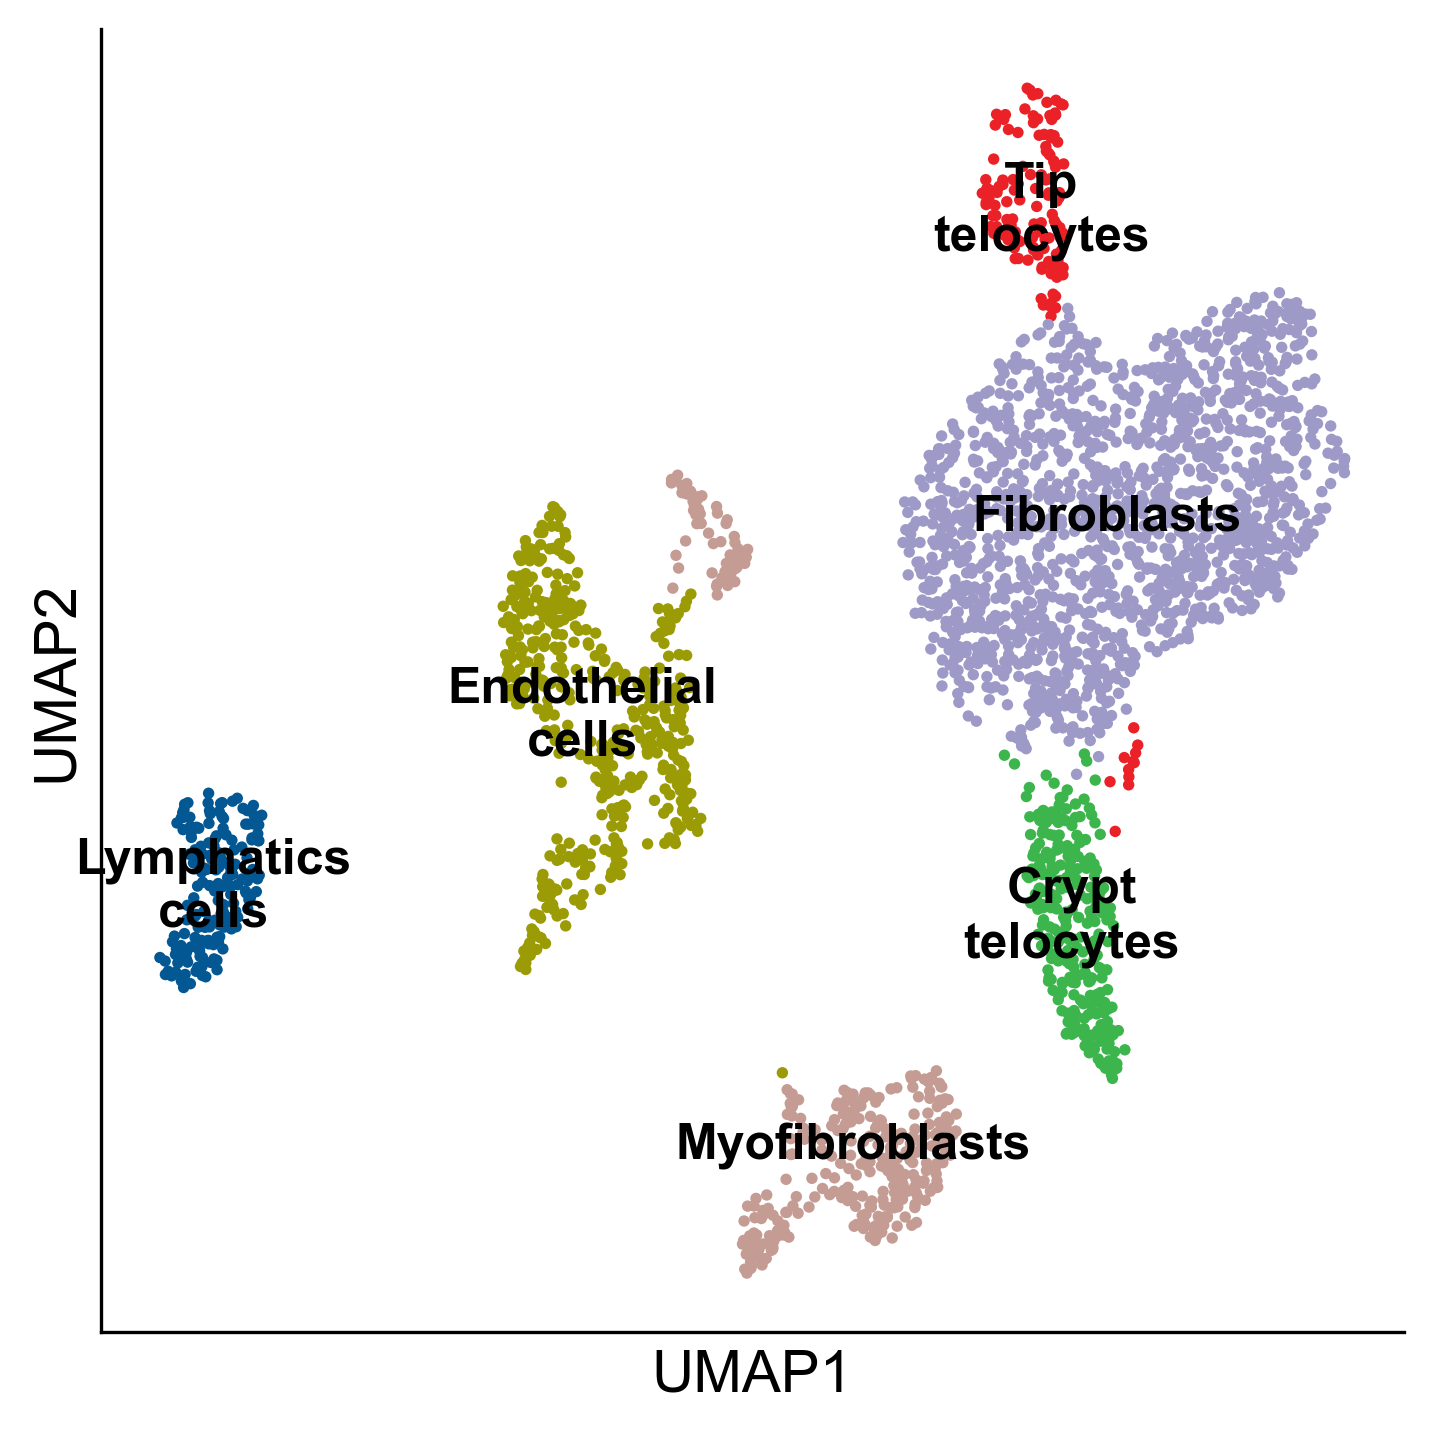

In [5]:
str_ad = adata[adata.obs['cell_type_lvl1'] == "Stroma", :].copy()
str_ad.obs['cell_type_lvl2'] = str_ad.obs['cell_type_lvl2'].str.replace('_', '-')

# drop clusters with less than 100 cells
MIN_CELLS_PER_CLUSTER = 100
cell_type_counts = str_ad.obs['cell_type_lvl2'].value_counts()
cell_types_to_keep = cell_type_counts[cell_type_counts >= MIN_CELLS_PER_CLUSTER].index
str_ad = str_ad[str_ad.obs['cell_type_lvl2'].isin(cell_types_to_keep), :].copy()


str_ad.obsm['X_umap'] = str_ad.obs[['stroma_umap1', 'stroma_umap2']].astype(float).to_numpy()
# drop values with NaN
str_ad = str_ad[~np.isnan(str_ad.obsm['X_umap']).any(axis=1), :]
print("# cells:", str_ad.n_obs)
  
# create color palette
unique_cell_types = str_ad.obs['cell_type_lvl2'].unique()
stroma_palette = {"Tip-telocytes": "#ea2228",#
                  "Fibroblasts": "#9e9ac8",#
                  "Myofibroblasts": "#c49c94",#
                  "Crypt-telocytes": "#3bb54c",#
                  "Endothelial-cells": "#9b9b06",
                  "Lymphatics-cells": "#035792",}

fig,ax = plt.subplots(figsize=(5,5), dpi=300)
sc.pl.umap(str_ad, color=['cell_type_lvl2'], legend_loc=None,
            legend_fontsize='medium',legend_fontoutline=1,
            show=False, ax=ax, size=30, palette=stroma_palette)

for cell_type in str_ad.obs['cell_type_lvl2'].unique():
    x = np.median(str_ad.obsm['X_umap'][str_ad.obs['cell_type_lvl2'] == cell_type, 0])
    y = np.median(str_ad.obsm['X_umap'][str_ad.obs['cell_type_lvl2'] == cell_type, 1])
    ax.text(x, y, cell_type.replace("-", "\n"), fontsize=12, weight='bold', color='black', ha='center', va='center')


plt.title("")
sns.despine()
plt.tight_layout()

# rasterize
for coll in ax.collections:
    coll.set_rasterized(True)

# export
export_path = f"{fig3_save_path}/Fig3A_stroma_umap2.pdf"
plt.savefig(export_path, bbox_inches='tight', dpi=300)

plt.show()


In [6]:
# load top and bottom genes
extreme_genes_df = pd.read_csv("extreme_genes.csv")
tip_markers = extreme_genes_df.loc[extreme_genes_df['category'] == "top","gene_name"].tolist()
bottom_markers = extreme_genes_df.loc[extreme_genes_df['category'] == "bottom","gene_name"].tolist()
print(tip_markers)
print(bottom_markers)

['BMP2', 'BMP2K', 'BMP5', 'BMP7', 'SFRP2', 'WNT11', 'WNT5A', 'WNT9B']
['GREM1', 'GREM2', 'RSPO2', 'RSPO3', 'WNT6']


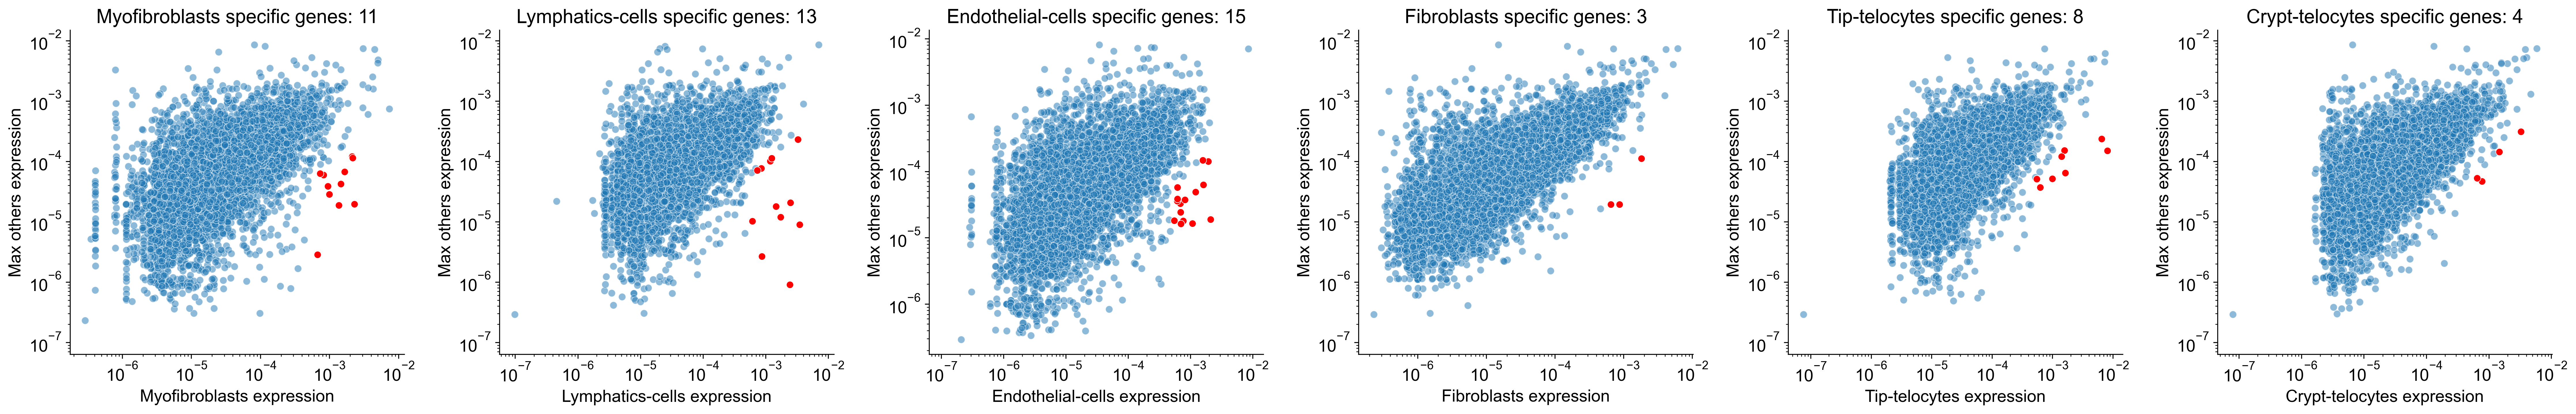

In [7]:
lvl2_types = str_ad.obs['cell_type_lvl2'].unique().tolist()
pb_lvl2 = pd.DataFrame(index=str_ad.var_names)
for my_compartment in lvl2_types:
    compartment_ad = str_ad[str_ad.obs['cell_type_lvl2'] == my_compartment].copy()
    pb_lvl2[my_compartment] = compartment_ad.layers['mat_norm'].mean(axis=0).A1
# identify compartment specific genes
FC_THRESH = 10
EXP_THRESH = 5e-4
compartment_specific_genes = {}
fig, axes = plt.subplots(1, len(lvl2_types), figsize=(5 * len(lvl2_types), 5), dpi=300)

for idx, my_compartment in enumerate(lvl2_types):
    my_compartment_expression = pb_lvl2.loc[:, my_compartment]
    other_compartments_max = pb_lvl2.loc[:, pb_lvl2.columns != my_compartment].max(axis=1)
    compartment_specific_genes[my_compartment] = pb_lvl2.index[
        (pb_lvl2.loc[:, my_compartment] > other_compartments_max * FC_THRESH) &
        (pb_lvl2.loc[:, my_compartment] > EXP_THRESH)
    ]

    ax = axes[idx]
    sns.scatterplot(x=my_compartment_expression, y=other_compartments_max, alpha=0.5, ax=ax)

    # scatter compartment specific genes
    sns.scatterplot(
        x=my_compartment_expression.loc[compartment_specific_genes[my_compartment]],
        y=other_compartments_max.loc[compartment_specific_genes[my_compartment]],
        color='red', ax=ax
    )

    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_xlabel(f"{my_compartment} expression")
    ax.set_ylabel("Max others expression")
    ax.set_title(f"{my_compartment} specific genes: {len(compartment_specific_genes[my_compartment])}")
    sns.despine()

plt.tight_layout()
plt.show()

In [8]:
# EXPORT TIP TELOCYTES DGE CED VS CONTROL
cond_dict = {'tip':['Tip-telocytes'],'bottom':['Myofibroblasts','Crypt-telocytes']}
EXP_THRESH = 1e-5
dge_df_dict = {}
for cond_name, cond_cell_types in cond_dict.items():
    tmptmp = str_ad[str_ad.obs['cell_type_lvl2'].isin(cond_cell_types)].copy()
    tmptmp.layers['mat_norm'] = tmptmp.layers['mat_norm'].toarray()
    mean_ced = tmptmp[tmptmp.obs['clinical_group'] == 'celiac'].layers['mat_norm'].mean(axis=0)
    mean_ct = tmptmp[tmptmp.obs['clinical_group'] == 'control'].layers['mat_norm'].mean(axis=0)

    PN = 1e-6
    mean_max_df = pd.DataFrame(index=str_ad.var_names)
    mean_max_df['mean_ced'] = mean_ced
    mean_max_df['mean_ct'] = mean_ct
    mean_max_df['max_mean'] = mean_max_df[['mean_ced', 'mean_ct']].max(axis=1)
    mean_max_df['log10_max_mean'] = np.log10(mean_max_df['max_mean'] + PN)
    mean_max_df['log2FC'] = np.log2((mean_max_df['mean_ced'] + PN) / (mean_max_df['mean_ct'] + PN))
    mean_max_df['p_value'] = np.nan
    mean_max_df['q_value'] = np.nan

    # identify expressed genes
    expressed_genes = mean_max_df.index[mean_max_df['max_mean'] > EXP_THRESH]
    mean_max_df = mean_max_df.loc[expressed_genes, :].copy()

    # perform ranksum test
    p_values = []
    ced_mat_norm = tmptmp[tmptmp.obs['clinical_group'] == 'celiac'].layers['mat_norm'].toarray()
    ct_mat_norm = tmptmp[tmptmp.obs['clinical_group'] == 'control'].layers['mat_norm'].toarray()
    for gene in tqdm(mean_max_df.index):
        gene_idx = tmptmp.var_names.get_loc(gene)
        ced_values = ced_mat_norm[:, gene_idx].flatten()
        ct_values = ct_mat_norm[:, gene_idx].flatten()
        stat, p_value = ranksums(ced_values, ct_values)
        p_values.append(p_value)
    mean_max_df['p_value'] = p_values
    # adjust p-values
    mean_max_df['q_value'] = multipletests(mean_max_df['p_value'], method='fdr_bh')[1]

    dge_df_dict[cond_name] = mean_max_df.copy()
    # export
    mean_max_df.to_csv(f"{cond_name}_dge_ced_ctrl.csv")

100%|██████████| 11875/11875 [00:07<00:00, 1683.92it/s]


tip DGE table shape: (10911, 8)


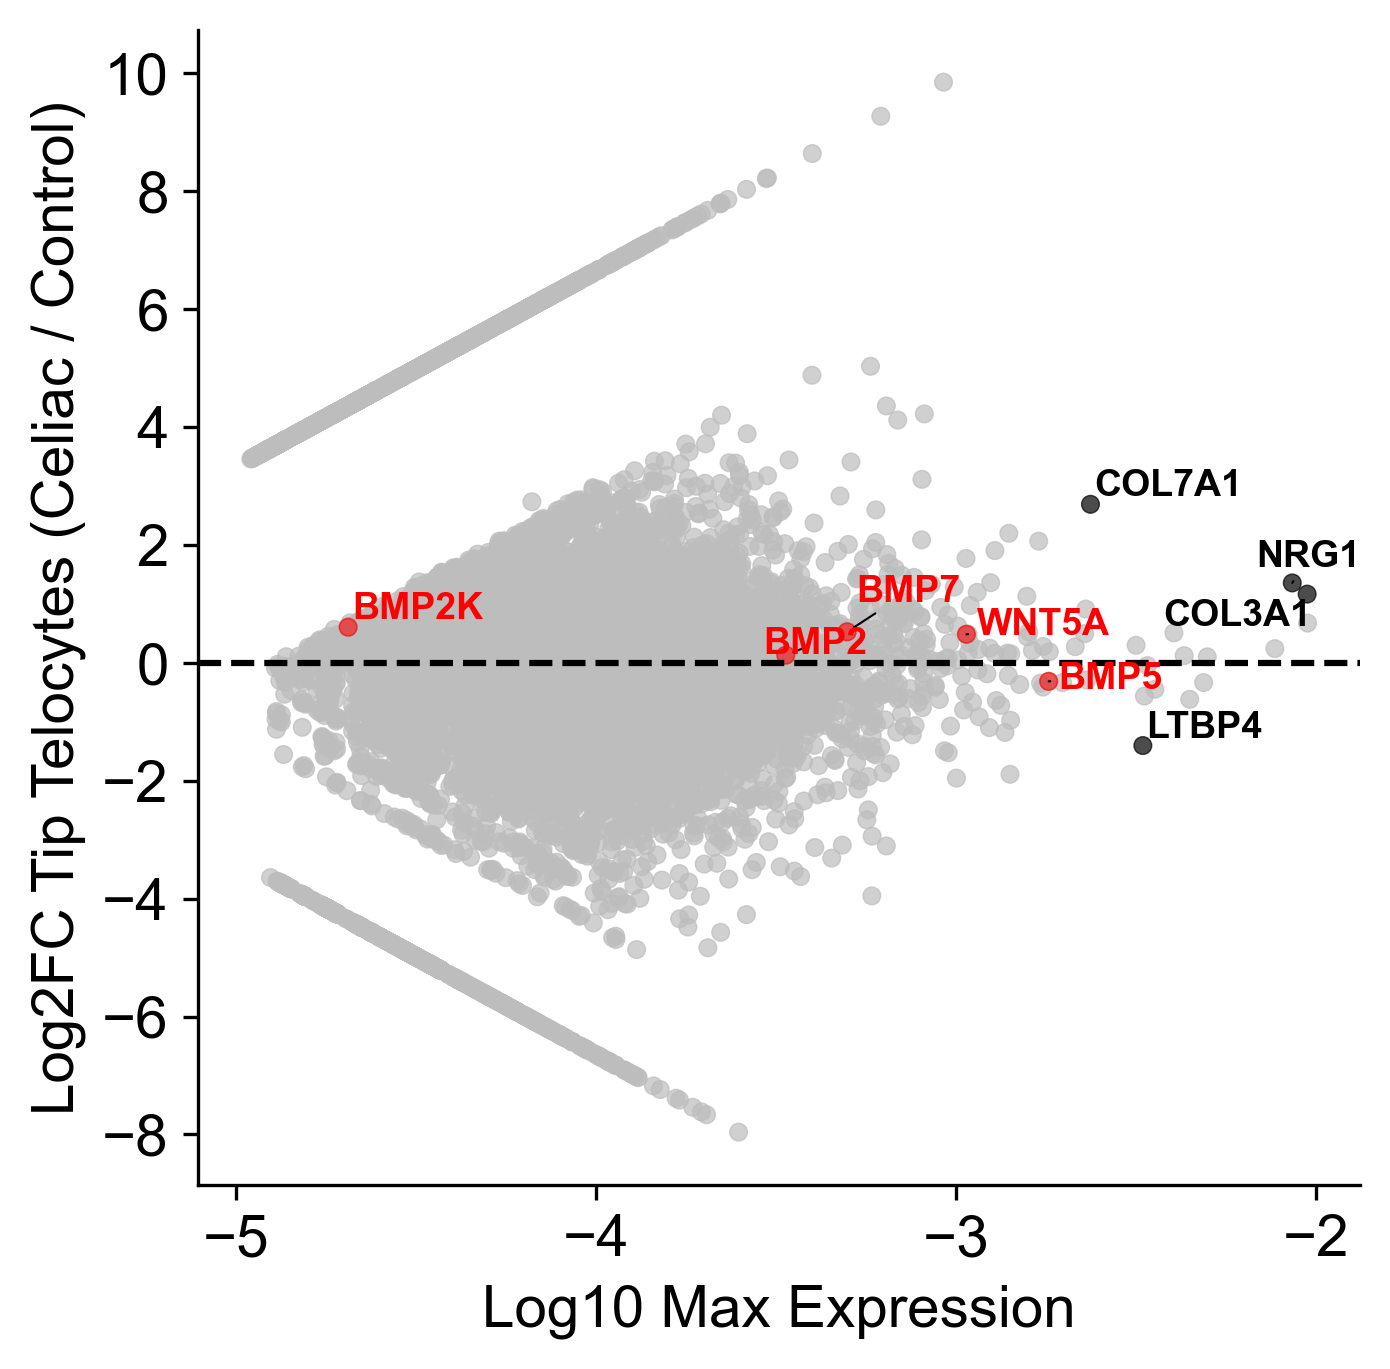

bottom DGE table shape: (11875, 8)


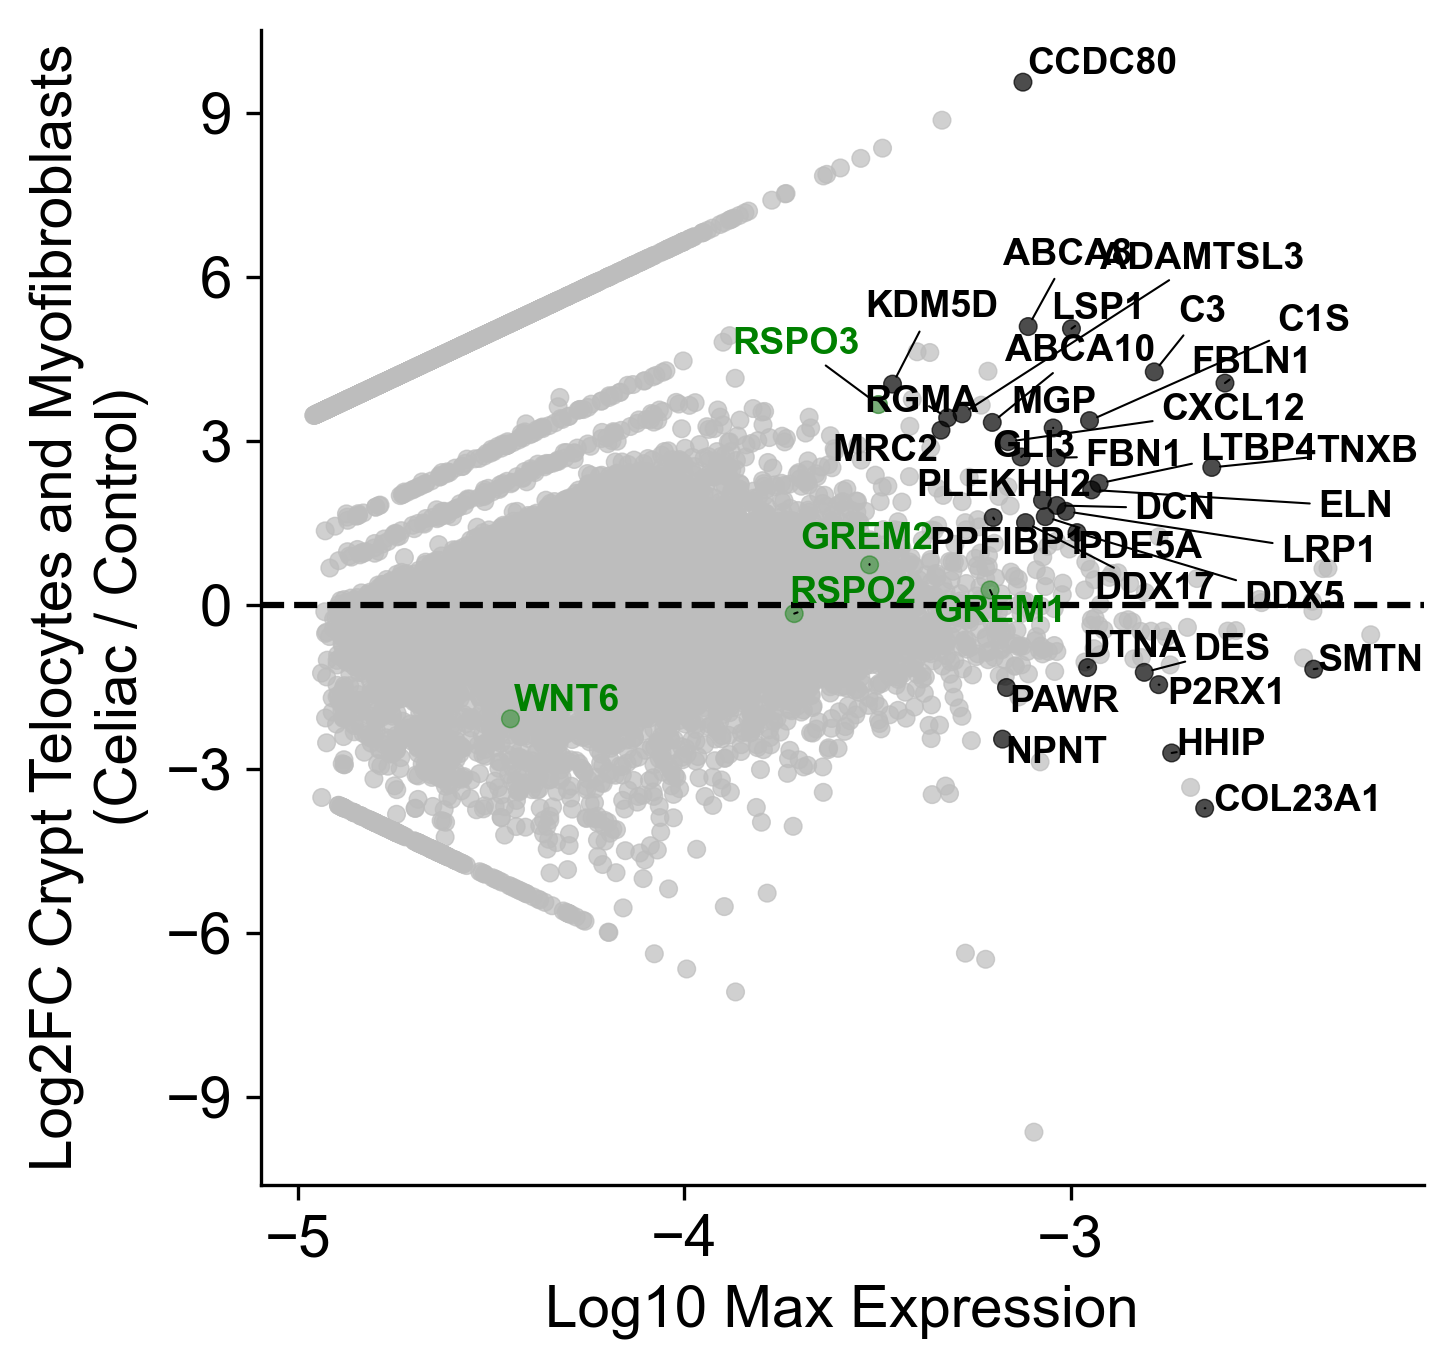

In [25]:
markers_dict = {'bottom': bottom_markers,#['DKK2', 'GREM1', 'GREM2', 'RSPO2', 'RSPO3', 'SFRP1', 'WNT9A'],
                'tip': tip_markers}#['BMP1', 'BMP2', 'BMP2K', 'BMP5', 'BMP7', 'BMP8B', 'SFRP2', 'SFRP5', 'WNT11', 'WNT5A', 'WNT9B']}
markers_colors = {'bottom': 'green', 'tip': 'red'}
title_dict = {'bottom': 'Crypt Telocytes and Myofibroblasts', 'tip': 'Tip Telocytes'}
for key in dge_df_dict.keys():
    print(f"{key} DGE table shape:", dge_df_dict[key].shape)
    my_df = dge_df_dict[key]

    Q_THRESH = 0.25
    FC_THRESH = 1
    my_df['significant'] = (my_df['q_value'] < Q_THRESH) & (np.abs(my_df['log2FC']) > FC_THRESH)

    spot_size = 8
    font_size = 9
    fig, ax = plt.subplots(figsize=(5,5), dpi=300)
    sns.scatterplot(x='log10_max_mean', y='log2FC', data=my_df[my_df['significant'] == False], alpha=0.7, ax=ax, size=spot_size, edgecolor=None, color='#bdbdbd')
    sns.scatterplot(x='log10_max_mean', y='log2FC', data=my_df[my_df['significant'] == True], alpha=0.7, ax=ax, size=spot_size, edgecolor=None, color='black')

    # show markers
    texts = []
    for zone in [key]:
        for marker in markers_dict[zone]:
            sns.scatterplot(x='log10_max_mean', y='log2FC', data=my_df[my_df.index.isin(markers_dict[zone])], alpha=0.1, ax=ax, size=spot_size, edgecolor=None, color=markers_colors[zone])
            if marker in my_df.index:
                gene_data = my_df.loc[marker, :]
                x = gene_data['log10_max_mean']
                y = gene_data['log2FC']
                significance = gene_data['significant']
                if significance:
                    texts.append(ax.text(x, y, marker, fontsize=font_size*2, color=markers_colors[zone]))
                else:
                    texts.append(ax.text(x, y, marker, fontsize=font_size, color=markers_colors[zone],fontweight='bold'))

    # add names for significant genes
    for gene in my_df.index[my_df['significant'] == True]:
        gene_data = my_df.loc[gene, :]
        x = gene_data['log10_max_mean']
        y = gene_data['log2FC']
        texts.append(ax.text(x, y, gene, fontsize=font_size,fontweight='bold'))

    # adjust text
    adjust_text(texts, ax=ax, arrowprops=dict(arrowstyle='-', color='black', lw=0.5), )

    # add line at y=0
    ax.axhline(0, color='black', linestyle='--')
    plt.xlabel('Log10 Max Expression')
    new_line_str = " "
    if key == "bottom":
        new_line_str = "\n"
    plt.ylabel(f'Log2FC {title_dict[key]}{new_line_str}(Celiac / Control)')
    # make y ticks ints
    ax.yaxis.set_major_locator(mpl.ticker.MaxNLocator(integer=True))

    # hide legend
    ax.legend_.remove()

    sns.despine()

    # raster
    for coll in ax.collections:
        coll.set_rasterized(True)

    # export
    export_path = f"{fig_telocyte_markers_save_path}/supp_figure_{key}_dge_ced_ctrl.pdf"
    plt.savefig(export_path, bbox_inches='tight', dpi=300)

    plt.show()

In [10]:
str_ad.obs.cell_type_lvl2.unique()

['Myofibroblasts', 'Lymphatics-cells', 'Endothelial-cells', 'Fibroblasts', 'Tip-telocytes', 'Crypt-telocytes']
Categories (6, object): ['Crypt-telocytes', 'Endothelial-cells', 'Fibroblasts', 'Lymphatics-cells', 'Myofibroblasts', 'Tip-telocytes']

Processing cell types for dotplot: 100%|██████████| 6/6 [00:00<00:00, 44.58it/s]


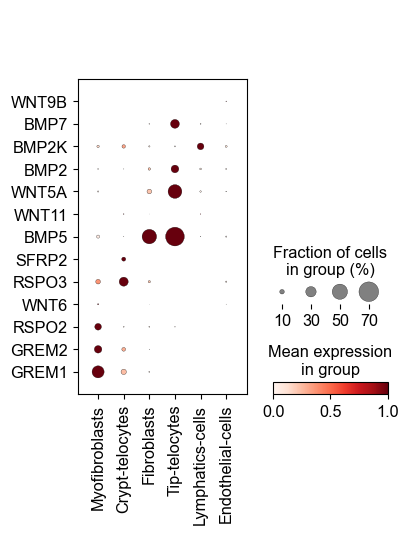

In [11]:
tmp_str_ad = str_ad.copy()
# remove genes with zero expression
# EXP_THERSH = 1e-5
# tmp_str_ad = tmp_str_ad[:, tmp_str_ad.layers['mat_norm'].mean(axis=0) > EXP_THERSH].copy()

cell_to_keep = ['Myofibroblasts', 'Crypt-telocytes', 'Fibroblasts', 'Tip-telocytes','Lymphatics-cells', 'Endothelial-cells']
tmp_str_ad = tmp_str_ad[tmp_str_ad.obs['cell_type_lvl2'].isin(cell_to_keep), :].copy()

# Remove genes with no expression
tmp_str_ad = tmp_str_ad[:, tmp_str_ad.layers['mat_norm'].sum(axis=0) > 0].copy()


# Initialize dotplot dataframe with zeros
dotplot_df = pd.DataFrame(0, index=tmp_str_ad.var_names, columns=cell_to_keep)
# Compute pseudobulk expression for each cell type
for my_cell in tqdm(dotplot_df.columns, desc="Processing cell types for dotplot"):
    cell_mask = tmp_str_ad.obs['cell_type_lvl2'] == my_cell
    dotplot_df.loc[:, my_cell] = np.asarray(tmp_str_ad[cell_mask].layers['mat_norm'].mean(axis=0)).flatten()

# reorder categories
new_cat_order = ['Myofibroblasts', 'Crypt-telocytes', 'Fibroblasts', 'Tip-telocytes','Lymphatics-cells', 'Endothelial-cells']

# Calculate the center of mass for each gene (column) in the dotplot dataframe
center_of_mass = dotplot_df.apply(lambda col: (col * np.arange(len(col))).sum() / col.sum(), axis=1)

bottom_com = center_of_mass[np.intersect1d(center_of_mass.index, markers_dict['bottom'])]
bottom_com = bottom_com.sort_values(ascending=False)

tip_com = center_of_mass[np.intersect1d(center_of_mass.index, markers_dict['tip'])]
tip_com = tip_com.sort_values(ascending=False)

combined_com = pd.concat([tip_com, bottom_com], axis=0)

dotplot_df.loc[combined_com.index].to_csv(f"{fig_telocyte_markers_save_path}/crypt_tip_morphos.csv")

# show fig
fig,ax = plt.subplots(figsize=(4,5))
sc.pl.dotplot(tmp_str_ad, var_names=combined_com.index,
    groupby='cell_type_lvl2', use_raw=False, swap_axes=True,
    categories_order=new_cat_order, standard_scale='var',smallest_dot=0,
    ax=ax,show=False)
export_path = f"{fig_telocyte_markers_save_path}/supp_fig_crypt_tip_morphogenes_dotplot.pdf"
plt.gcf().savefig(export_path, bbox_inches='tight', dpi=300)
plt.show()

In [12]:
# recalculate log z score
str_ad.layers['log_zscore'] = str_ad.layers['log_norm'].copy()
sc.pp.scale(str_ad, layer='log_zscore', zero_center=True, max_value=10)

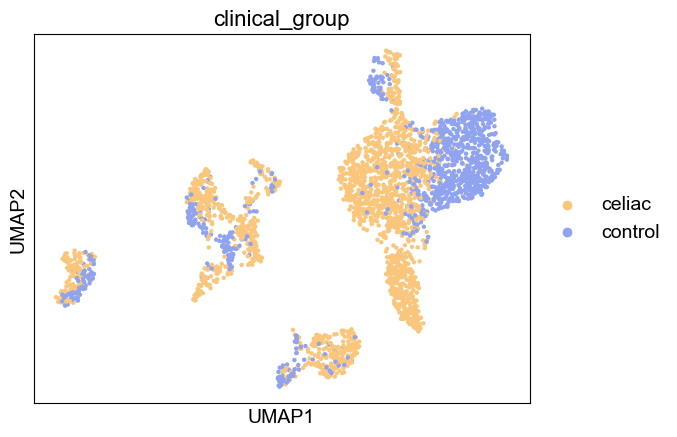

In [13]:
sc.pl.umap(str_ad, color=['clinical_group'], cmap='viridis', vmax='p99', layer='mat_norm')

In [14]:
# create mean expression matrix for each cluster
mean_exp = pd.DataFrame(index=str_ad.var_names, columns=str_ad.obs['cell_type_lvl2'].unique())
for cell_type in str_ad.obs['cell_type_lvl2'].unique():
    mean_exp.loc[:, cell_type] = str_ad[str_ad.obs['cell_type_lvl2'] == cell_type, :].layers['mat_norm'].mean(axis=0)

# drop columns - lymphatics-cells and endothelial-cells
mean_exp = mean_exp.drop(columns=['Lymphatics-cells','Endothelial-cells',"Fibroblasts"])

EXP_THRESH = 1e-5
FC_THRESH = 1.5
PN=1e-6

# calculate markers for each cell type using the mean_expression matrix
markers = {}
for cell_type in mean_exp.columns.tolist():
    other_cell_types = [ct for ct in mean_exp.columns.tolist() if ct != cell_type]
    cell_type_exp = mean_exp.loc[:, cell_type]
    other_exp = mean_exp.loc[:, other_cell_types].max(axis=1)
    
    # calculate fold change
    fold_change = (cell_type_exp + PN) / (other_exp + PN)
    
    # select markers based on expression and fold change thresholds
    selected_markers = fold_change[(cell_type_exp > EXP_THRESH) & (fold_change >= FC_THRESH)].index.tolist()
    markers[cell_type] = selected_markers

In [15]:
# # find markers with minimal expression between clusters
# # bmps = ["BMP5","BMP7","BMP1","BMP8A","BMP8B"]#str_ad.var_names[str_ad.var_names.str.startswith("BMP")].tolist()
# # rspos = ["RSPO2","RSPO3"]#str_ad.var_names[str_ad.var_names.str.startswith("RSPO")].tolist()
# # grems = ["GREM1","GREM2"]#str_ad.var_names[str_ad.var_names.str.startswith("GREM")].tolist()
# # wnts = ["WNT2","WNT6","WNT9A","WNT2B","WNT10B","WNT4"]#str_ad.var_names[str_ad.var_names.str.startswith("WNT")].tolist()

# tip_morphs = ["BMP5","BMP7","BMP1","BMP8A","BMP8B","WNT5A","WNT9B","WNT11"]
# crypt_morphs = ["GREM1","GREM2","BMP4","BMP3","WNT2","WNT6","RSPO3","WNT9A","RSPO2"]

# # Filter tip_morphs and crypt_morphs to keep only markers present in the markers dictionary
# all_markers = set(gene for marker_list in markers.values() for gene in marker_list)
# tip_morphs = [gene for gene in tip_morphs if gene in all_markers]
# crypt_morphs = [gene for gene in crypt_morphs if gene in all_markers]

# # Select BMPs, RSPOs, GREMs, WNTs as markers
# # selected_markers = {}
# # for cell_type, marker_list in markers.items():
# #     selected = [gene for gene in marker_list if gene in tip_morphs + crypt_morphs]
# #     if selected:
# #         selected_markers[cell_type] = selected
# # selected_markers
# tip_morphs# = [gene for gene in tip_morphs if gene in all_markers]
# # crypt_morphs

In [16]:
# find the smallest cluster size
smallest_cluster_size = str_ad.obs['cell_type_lvl2'].value_counts()[-1]
smallest_cluster_name = str_ad.obs['cell_type_lvl2'].value_counts().index[-1]
print("Smallest cluster:", smallest_cluster_name, "with", smallest_cluster_size, "cells")
subsampled_str_ad = str_ad[str_ad.obs['cell_type_lvl2'] == smallest_cluster_name, :].copy()
for cell_type in str_ad.obs['cell_type_lvl2'].unique():
    if cell_type == smallest_cluster_name:
        continue
    cell_type_ad = str_ad[str_ad.obs['cell_type_lvl2'] == cell_type, :].copy()
    sampled_ad = cell_type_ad[np.random.choice(cell_type_ad.n_obs, smallest_cluster_size, replace=False), :].copy()
    subsampled_str_ad = subsampled_str_ad.concatenate(sampled_ad)

print("Subsampled adata shape:", subsampled_str_ad.shape)

Smallest cluster: Tip-telocytes with 140 cells
Subsampled adata shape: (840, 18129)


In [17]:
# ### SAME CODE BLOCK EXISTS IN 06_reconstruct_zonation.ipynb ###

# MIN_EXP = 1e-5
# control_non_epi_com_path = os.getcwd()+"/group_com_zonation/group_com_zonation_control_non_epithelium.csv"
# com_df = pd.read_csv(control_non_epi_com_path, index_col=0)
# com_df_filtered = com_df.loc[:,com_df.columns.str.contains("_mean")]
# com_df_filtered.mean(axis=1)
# # create scatter_df with com_df_filtered.mean(axis=1) as 'mean_non_epithelium_exp' and com_df.loc[:,'com']
# scatter_df = pd.DataFrame({
#     'mean_non_epithelium_exp':com_df_filtered.mean(axis=1),
#     'log10_mean_non_epithelium_exp': np.log10(com_df_filtered.mean(axis=1) + 1e-6),
#     'com': com_df.loc[:,'com_01'],
#     'selected':False
# })

# scatter_df = scatter_df.loc[scatter_df['mean_non_epithelium_exp'] > MIN_EXP]


# starts_to_keep = ["GREM","WNT","RSPO","BMP"]
# scatter_df = scatter_df[scatter_df.index.str.startswith(tuple(starts_to_keep))]

# # select the most extreme N genes based on com
# N = 5
# top_genes = scatter_df.sort_values(by='com', ascending=False).head(N).index.tolist()
# bottom_genes = scatter_df.sort_values(by='com', ascending=True).head(N).index.tolist()
# extreme_genes = top_genes + bottom_genes
# scatter_df.loc[extreme_genes, 'selected'] = True

# print("Selected top genes:", top_genes)
# print("Selected bottom genes:", bottom_genes)
# px.scatter(scatter_df, x='log10_mean_non_epithelium_exp', y='com', color='selected', hover_name=scatter_df.index)

In [18]:
# reorder: myofibroblasts crypt Tip fibroblasts lympahtics endothelial
subsampled_str_ad.obs['cell_type_lvl2'] = subsampled_str_ad.obs['cell_type_lvl2'].cat.reorder_categories([
    "Myofibroblasts",
    "Crypt-telocytes",
    "Tip-telocytes",
    "Fibroblasts",
    "Lymphatics-cells",
    "Endothelial-cells"
])

In [19]:
# update color palette - important!
updated_color_list = []
for cat in subsampled_str_ad.obs['cell_type_lvl2'].cat.categories:
    updated_color_list.append(stroma_palette[cat])
subsampled_str_ad.uns['cell_type_lvl2_colors'] = updated_color_list
print(subsampled_str_ad.uns['cell_type_lvl2_colors'])

['#c49c94', '#3bb54c', '#ea2228', '#9e9ac8', '#035792', '#9b9b06']


In [20]:
# select markers using different method to insure absence of duplicate genes
EXP_THRESH = 1e-4
PN= 1e-6
MIN_FC = 2
markers_dict = {}
for cell_type in subsampled_str_ad.obs['cell_type_lvl2'].cat.categories:
    cell_type_ad = subsampled_str_ad[subsampled_str_ad.obs['cell_type_lvl2'] == cell_type, :].copy()
    other_ad = subsampled_str_ad[subsampled_str_ad.obs['cell_type_lvl2'] != cell_type, :].copy()
    
    # calculate mean expression
    cell_type_mean_exp = np.asarray(cell_type_ad.layers['mat_norm'].mean(axis=0)).flatten()
    other_mean_exp = np.asarray(other_ad.layers['mat_norm'].mean(axis=0)).flatten()
    
    # calculate fold change
    fold_change = (cell_type_mean_exp + PN) / (other_mean_exp + PN)
    
    # select markers based on expression and fold change thresholds
    selected_markers = subsampled_str_ad.var_names[(cell_type_mean_exp > EXP_THRESH) & (fold_change >= MIN_FC)].tolist()
    # sort selected markers by fold change in descending order
    selected_markers = sorted(selected_markers, key=lambda gene: (cell_type_mean_exp[subsampled_str_ad.var_names.get_loc(gene)] + PN) / (other_mean_exp[subsampled_str_ad.var_names.get_loc(gene)] + PN), reverse=True)
    markers_dict[cell_type] = selected_markers

N_markers = 5
united_markers = []
for cell_type, marker_list in markers_dict.items():
    top_n_markers = marker_list[:N_markers]
    united_markers.extend(top_n_markers)


In [21]:
sc.tl.rank_genes_groups(subsampled_str_ad, groupby='cell_type_lvl2', method='wilcoxon', layer='log_norm', n_genes=subsampled_str_ad.n_vars)
# create a dict of the two top markers for each cluster
N_markers = 3
top_markers = {}
for cell_type in subsampled_str_ad.obs['cell_type_lvl2'].cat.categories:
    markers_df = sc.get.rank_genes_groups_df(subsampled_str_ad, group=cell_type)
    top_genes_N = markers_df['names'].head(N_markers).tolist()
    top_markers[cell_type+"\nmarkers"] = top_genes_N

# add top and bottom genes
# top_markers['Tip\nmorphogenes'] = top_com_genes
# top_markers['Crypt\nmorphogenes'] = bottom_com_genes
top_markers

{'Myofibroblasts\nmarkers': ['TPM1', 'MYH11', 'ADAM33'],
 'Crypt-telocytes\nmarkers': ['FBLN1', 'C3', 'LRP1'],
 'Tip-telocytes\nmarkers': ['F3', 'NRG1', 'OBSCN'],
 'Fibroblasts\nmarkers': ['COL18A1', 'TNXB', 'ADAMDEC1'],
 'Lymphatics-cells\nmarkers': ['FLT4', 'PPFIBP1', 'EGFL7'],
 'Endothelial-cells\nmarkers': ['EGFL7', 'PECAM1', 'ADAM15']}

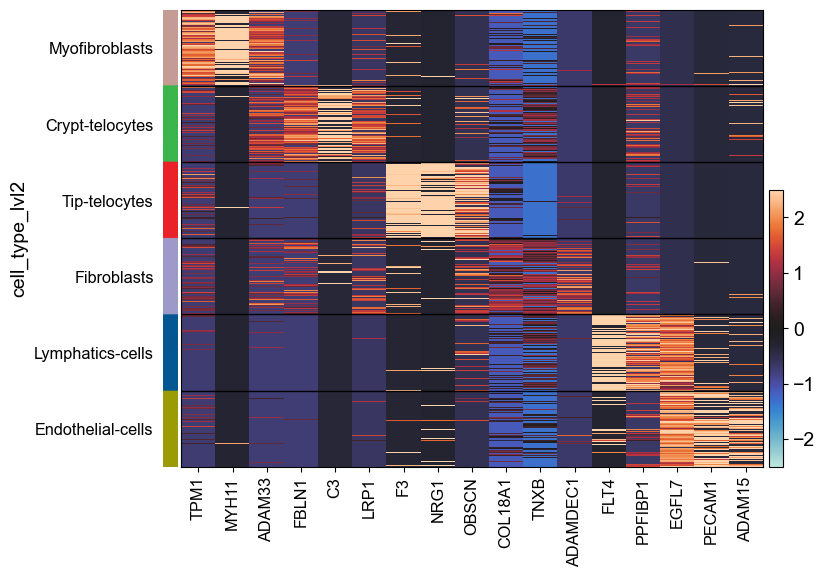

In [22]:
VMIN_MAX = 2.5
top_markers_list = []
for markers in top_markers.values():
    top_markers_list.extend(markers)

# if there is duplicates - remove them
top_markers_list = list(dict.fromkeys(top_markers_list))

sc.pl.heatmap(subsampled_str_ad, top_markers_list, groupby='cell_type_lvl2', layer='log_zscore',
                                 cmap='icefire', vmax=VMIN_MAX, vmin=-VMIN_MAX, #swap_axes=True,
                                 show=False, figsize=(8,6))#, var_group_labels=False)
export_path = f"{fig3_save_path}/Fig3B_stroma_marker_genes_heatmap.pdf"
plt.gcf().savefig(export_path, bbox_inches='tight', dpi=300)

In [23]:
# sc.pl.rank_genes_groups_heatmap(subsampled_str_ad, n_genes=5, groupby='cell_type_lvl2', layer='log_zscore',
#                                  cmap='icefire', vmax=VMIN_MAX, vmin=-VMIN_MAX, 
#                                  show=False, figsize=(8,8))

# # change ylabel to "Cell type"
# ax = plt.gca()
# ax.set_ylabel("Cell type")

# # save figure
# # export_path = f"{os.getcwd()}/figures/fig3B_stroma_marker_genes_heatmap.pdf"
# # plt.gcf().savefig(export_path, bbox_inches='tight', dpi=300)

In [24]:
print(session_info2.session_info(dependencies=True))

pandas	2.3.1
anndata	0.12.0
scanpy	1.11.3
seaborn	0.13.2
matplotlib	3.10.3
numpy	2.2.6
plotly	6.2.0
adjustText	1.3.0
tqdm	4.67.1
gseapy	1.1.9
scipy	1.15.3
scikit-learn	1.7.1
statsmodels	0.14.5
dill	0.4.0
----	----
asttokens	3.0.0
Pygments	2.19.2
sphinxcontrib-qthelp	2.0.0
parso	0.8.4
six	1.17.0
Deprecated	1.2.18
xarray	2025.9.0
ipykernel	6.29.5
psutil	7.0.0
h5py	3.14.0
ipython	9.4.0
sphinxcontrib-applehelp	2.0.0
narwhals	1.47.1
texttable	1.7.0
setuptools	78.1.1
numcodecs	0.15.1
pyarrow	21.0.0
python-dateutil	2.9.0.post0
zarr	2.18.7
session-info2	0.1.2
igraph	0.11.9
dask	2024.11.2
platformdirs	4.3.8
toolz	1.0.0
wrapt	1.17.2
Jinja2	3.1.6
idna	3.10
urllib3	2.5.0
certifi	2025.7.14 (2025.07.14)
debugpy	1.8.15
wcwidth	0.2.13
sphinxcontrib-devhelp	2.0.0
MarkupSafe	3.0.2
matplotlib-inline	0.1.7
sphinxcontrib-jsmath	1.0.1
traitlets	5.14.3
comm	0.2.2
PyYAML	6.0.2
leidenalg	0.10.2
asciitree	0.3.3
fonttools	4.59.0
zipp	3.23.0
sphinxcontrib-htmlhelp	2.1.0
pillow	11.3.0
requests	2.32.4
threadpoolctl